<h3>Now, lets classify the processed movie reviews.</h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('IMDB_reviews_processed_uncased.csv')
df.head()

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,positive
1,wonderful little production film technique una...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically family little boy jake think zombie ...,negative
4,petter matteis love time money visually stunni...,positive


<h1>1) Assigning numeric labels to sentiment classes</h1>

In [2]:
def sent_to_int(sent):
  if sent == "negative":
    return 0
  else:
    return 1

df['sentiment'] = df['sentiment'].apply(sent_to_int)
df.head(2)

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,1
1,wonderful little production film technique una...,1


In [3]:
!nvidia-smi

Mon Jul 20 03:18:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<h1>2) Installing requirements</h1>

In [4]:
!pip install -q -U watermark
!pip install -qq transformers

     |████████████████████████████████| 778kB 8.5MB/s 
     |████████████████████████████████| 1.1MB 13.0MB/s 
     |████████████████████████████████| 3.0MB 58.0MB/s 
     |████████████████████████████████| 890kB 61.7MB/s 


In [5]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.0.5
torch 1.5.1+cu101
transformers 3.0.2


<h1>3) Using installed libraries</h1>

In [6]:
# Ignore warnings
import logging
logging.basicConfig(level=logging.ERROR)

In [7]:
# Importing Hugging Face transformers library
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

#Loading BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [9]:
# Experimenting on a single sample
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 0, 'Token count')

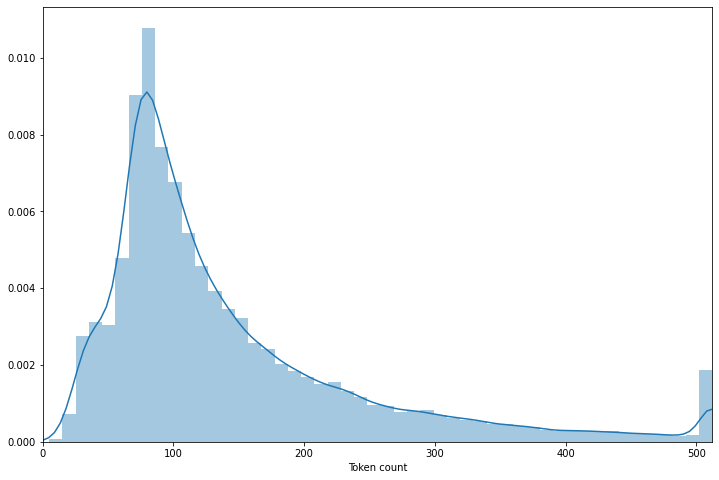

In [10]:
# Looking at distribution of review length
import seaborn as sns

token_lens = []

for txt in df.review:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

plt.figure(figsize=(12,8))
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count')

<h1>4) Using custom Dataset & DataLoader class</h1>

In [11]:
# Choosing maximum sequence length. Any sentence with lesser length will be padded.
MAX_LEN = 280

In [12]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [13]:
class MovieReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [14]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [15]:
df_train.head(2)

,review,sentiment
39087,keep ask many fight scream match swear general...,0
30893,not watch entire movie could not watch entire ...,0


In [16]:
print("Train size : {}".format(df_train.shape[0]))
print("Validation size : {}".format(df_val.shape[0]))
print("Test size : {}".format(df_test.shape[0]))

Train size : 40000
Validation size : 5000
Test size : 5000


In [17]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MovieReviewDataset(
    reviews=df.review.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [18]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [19]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [20]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 280])
torch.Size([16, 280])
torch.Size([16])


In [21]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [22]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [23]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [24]:
bert_model.config.hidden_size

768

In [25]:
pooled_output.shape

torch.Size([1, 768])

<h1>5) Creating custom classifier class</h1>

In [26]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [27]:
class_names = [0,1]

model = SentimentClassifier(len(class_names))
model = model.to(device)

In [28]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 280])
torch.Size([16, 280])


In [29]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5514, 0.4486],
        [0.5571, 0.4429],
        [0.5141, 0.4859],
        [0.5003, 0.4997],
        [0.5394, 0.4606],
        [0.5218, 0.4782],
        [0.5562, 0.4438],
        [0.4938, 0.5062],
        [0.7165, 0.2835],
        [0.5443, 0.4557],
        [0.4920, 0.5080],
        [0.6205, 0.3795],
        [0.5193, 0.4807],
        [0.5637, 0.4363],
        [0.4917, 0.5083],
        [0.5733, 0.4267]], device='cuda:0', grad_fn=<SoftmaxBackward>)

<h1>6) Setting model hyperparameters</h1>

In [30]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

<h1>7) Training the model</h1>

In [31]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [32]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import time

In [34]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  st = time.time()
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )
  
  print(f'Train loss : {train_loss} Train accuracy : {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )
  
  en = time.time()
  print(f'Val   loss : {val_loss} Val   accuracy : {val_acc}')
  print("Time taken for epoch-{} is {} mins".format(epoch+1, (en-st)/60))  
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss : 0.4062202504277229 Train accuracy : 0.836225
Val   loss : 0.3390541662470982 Val   accuracy : 0.8572000000000001
Time taken for epoch-1 is 34.868914703528084 mins

Epoch 2/10
----------
Train loss : 0.29592749951183794 Train accuracy : 0.8976500000000001
Val   loss : 0.2680852641217625 Val   accuracy : 0.8882
Time taken for epoch-2 is 34.96794674793879 mins

Epoch 3/10
----------
Train loss : 0.24790052196905016 Train accuracy : 0.9218000000000001
Val   loss : 0.3012771999683624 Val   accuracy : 0.8912
Time taken for epoch-3 is 34.94392048915227 mins

Epoch 4/10
----------
Train loss : 0.20778710685521365 Train accuracy : 0.9431750000000001
Val   loss : 0.39989113285780525 Val   accuracy : 0.8956000000000001
Time taken for epoch-4 is 34.892109497388205 mins

Epoch 5/10
----------
Train loss : 0.17040126760154964 Train accuracy : 0.9564
Val   loss : 0.4298091704983966 Val   accuracy : 0.8964000000000001
Time taken for epoch-5 is 34.862007876237236 mins

In [35]:
torch.cuda.get_device_name(0)

'Tesla T4'

<h1>8) Plotting model performance</h1>

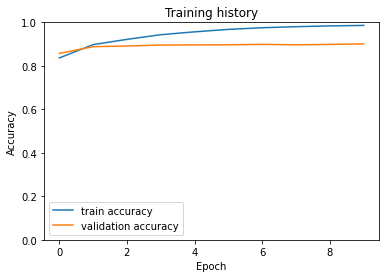

In [36]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

<h1>9) Checking model performance on test set</h1>

In [37]:
# Evaluation
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9022

<h1>10) Results</h1>

**Validation accuracy 90.1, Test accuracy 90.22**